# Results
This notebook was created to form the results into more human-freandly form

"Form results table" helps to pork with results_2 for mpipe, smpl, and ntu datasets (The first experiment in the report)

"CV Results" - work with CV results (The second experiment in the report).

In [1]:
%load_ext autoreload
%autoreload 1
%aimport modules.results_auxiliary
# %aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.bullets, modules.results_auxiliary, modules.bullets

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import copy
import time
import json
import timeit

# from modules.bullets import*
# from modules.classification_auxiliary import *
# from modules.ml_auxiliary import *
from modules.results_auxiliary import *


import pathlib
import seaborn as sns


# Form results table

In [5]:
# Input
src = 'stages/results_2-mpipe/'


#script
form_table, get_fancy_table= form_table_v2, get_fancy_table_v2


src_list = get_target_files(src)
df = form_table(src_list)
table = get_fancy_table(df)
df_f = filter_acc(src, drop_classes=[16])
table = table.merge(df_f[['model', 'acc_drop_fancy', 'acc_merge_fancy']], on='model')


# Acc_drop is if geture with label 16 (G17_left_write) was dropped
# Ass_merge is if geture with labels 16(G17_left_write) and 17 (G18_right_write)) are merged into label 17 (G18_right_write)
# (gesture name) from gesture.txt
table



,model,"Accuracy, %","Inference time, ms","Fitting time, s",acc_drop_fancy,acc_merge_fancy
0,SVD_max+KNN: {},36.47,191.324,0.01,36.43,36.47
1,"SVD_max+LogReg: {'class_weight': 'balanced', '...",91.14,0.475,26.83,91.12,91.14
2,"SVD_max+RandForest: {'n_estimators': 300, 'max...",3.08(0.15),77.234,37.61,3.06,3.05
3,SVD_max+STMM: {},71.65(0.16),1.076,948.2,71.67,71.68
4,SVD_max+SVMClassifier: {},91.08,8.53,30.36,91.12,91.08
5,SVD_max+XGBoost: {'n_estimators': 300},70.96,1.887,1433.73,71.07,70.96
6,original+KNN: {},49.4,108.482,0.09,49.28,49.40
7,"original+LogReg: {'class_weight': 'balanced', ...",92.81,0.333,2427.76,92.80,92.81
8,"original+RandForest: {'n_estimators': 300, 'ma...",95.69(0.15),46.871,30.07,96.04,95.99
9,original+STMM: {},95.86(0.17),25.565,2493.14,95.86,95.87


In [4]:
# # For checking


# file_pkl = src + 'model1-skgest-smpl-center_tucker_full.pkl'
# with open(file_pkl, 'rb') as f:
#     data = pickle.load(f)
            
# preds, y_test = data['preds'], data['y_test']
        

# CV results

In [4]:
table

,Accuracy,Model
P01,0.920755,LR
P02,0.924528,LR
P03,0.981132,LR
P04,0.928302,LR
P05,0.879245,LR
...,...,...
P17_SVD_max,0.679245,STMM
P18_SVD_max,0.735849,STMM
P19_SVD_max,0.611321,STMM
P20_SVD_max,0.701887,STMM


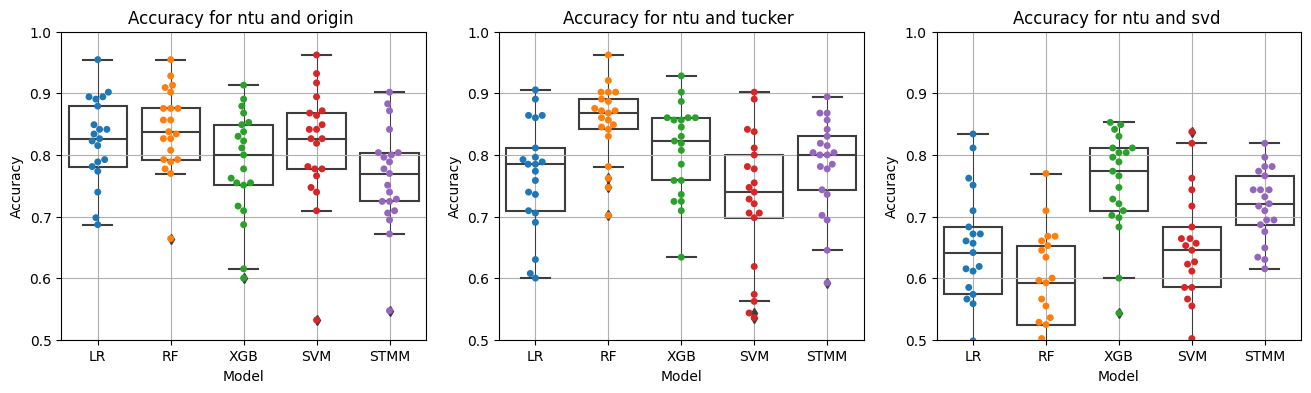

In [8]:
# Gettung plots to CV results

# Input
# Select dataset
skelet = 'ntu'
t_src = 'stages/results_cv/model{n_model}-skgest-{skelet}-center-folds{transform}.json'

# script
skelets = ['mpipe', 'ntu', 'smpl']
transform_pairs = [['origin', ''], ['tucker', '_tucker_full'], 
                   ['svd', '_SVD_max']]


name_dict = {'LogReg': 'LR', 'RandForest': 'RF', 'XGBoost': 'XGB', 'SVMClassifier':'SVM'}
# name_dict = {'LogReg': 'LR', 'RandForest': 'RF', 'XGBoost': 'XGB', 'SVMClassifier':'SVM', 'STMM':'STMM'}


figure, axes = plt.subplots(1, 3, figsize=(16, 4))
table_dict = {}
for i, transform_pair in enumerate(transform_pairs):
    ax = axes[i]
    acc_dicts, model_names = [], []
    try:
        for n_model in [1, 2, 3, 4, 5]:
            
                src = t_src.format(n_model=n_model, skelet=skelet, transform=transform_pair[1])
                if os.path.exists(src):
                    acc_dict, model_name = collect_accuracy(src)
                    acc_dicts += [acc_dict]
                    model_names += [model_name]
                
        table = form_common_table(acc_dicts, model_names, name_dict=name_dict)
        table_dict[f"{skelet}-{transform_pair[0]}"] = table
        
        plot_swarmboxplot(table, ax=ax,)
        ax.set_ylim([0.5, 1])
        ax.set_title(f"Accuracy for {skelet} and {transform_pair[0]} ")
        ax.grid()
        # plt.show()
                         
    except:
        print(f"Accuracy for {skelet} and {transform_pair[0]} was skipped")
        

In [5]:
# mean and std values
for transform in ['origin', 'tucker', 'svd']:  
    for model in ['LR', 'RF', 'XGB', 'SVM', 'STMM']:
    
        key = f"{skelet}-{transform}"
        table_ = table_dict[key]
        mean_acc = table_[table_['Model'] == model]['Accuracy'].mean()
        std_acc = table_[table_['Model'] == model]['Accuracy'].std(ddof=1)
        print(key, model,  f"{100*mean_acc:.2f}({100*std_acc:.2f})", sep='\t')

mpipe-origin	LR	82.07(9.84)
mpipe-origin	RF	90.66(5.20)
mpipe-origin	XGB	84.62(8.20)
mpipe-origin	SVM	80.68(9.71)
mpipe-origin	STMM	85.59(9.20)
mpipe-tucker	LR	88.37(6.96)
mpipe-tucker	RF	94.50(3.88)
mpipe-tucker	XGB	89.00(6.89)
mpipe-tucker	SVM	71.59(13.02)
mpipe-tucker	STMM	84.35(8.55)
mpipe-svd	LR	86.16(7.47)
mpipe-svd	RF	3.16(0.55)
mpipe-svd	XGB	66.81(7.83)
mpipe-svd	SVM	86.40(7.55)
mpipe-svd	STMM	68.28(7.77)
